# LightGBM Car Price Prediction

This notebook trains a LightGBM regressor to predict car prices using `cleaned_autocentral_data.csv`.

It follows these steps:
- Load and inspect data
- Preprocess categorical features (fill NaNs, ordinal-encode)
- Train LightGBM with early stopping
- Evaluate RMSE / MAE / R²
- Save model and encoder


In [7]:
# If LightGBM is not installed, uncomment and run:
# !pip install lightgbm scikit-learn pandas numpy joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

RANDOM_STATE = 42
DATA_PATH = "cleaned_autocentral_data.csv"
TARGET_COLUMN = "price"


In [8]:
# Load dataset and prepare features/target

df = pd.read_csv(DATA_PATH)

if TARGET_COLUMN not in df.columns:
    raise ValueError(f"Target column '{TARGET_COLUMN}' not found in dataset.")

X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

print("Data shape:", df.shape)
print("Features shape:", X.shape)
print("Target shape:", y.shape)

# Identify categorical features
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()
print("Categorical features:", categorical_features)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Data shape: (11387, 8)
Features shape: (11387, 7)
Target shape: (11387,)
Categorical features: ['brand', 'model']
Train size: 9109
Test size: 2278


In [9]:
# Handle missing categorical values and encode them with OrdinalEncoder

# Fill NaNs in categorical columns
for col in categorical_features:
    X_train[col] = X_train[col].fillna('Unknown')
    X_test[col] = X_test[col].fillna('Unknown')

# Ordinal encode categorical features so LightGBM can use them as categorical indices
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
if categorical_features:
    X_train[categorical_features] = encoder.fit_transform(X_train[categorical_features])
    X_test[categorical_features] = encoder.transform(X_test[categorical_features])

print("Missing values after handling (train):")
if categorical_features:
    print(X_train[categorical_features].isnull().sum())
else:
    print("No categorical features detected.")


Missing values after handling (train):
brand    0
model    0
dtype: int64


In [ ]:
# Create LightGBM datasets and train the model

# Get categorical feature indices (LightGBM accepts indices for categorical features)
cat_indices = [X_train.columns.get_loc(col) for col in categorical_features] if categorical_features else []

train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_indices, free_raw_data=False)
valid_data = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_indices, free_raw_data=False)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_leaves': 80,
    'max_depth': 10,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'min_data_in_leaf': 10,
    'min_gain_to_split': 0.01,
    'lambda_l1': 0.1,
    'lambda_l2': 3.0,
    'boosting': 'gbdt',
    'seed': RANDOM_STATE,
    'verbosity': -1,
}

# Use callback-based early stopping and logging for compatibility with the installed LightGBM
bst = lgb.train(
    params,
    train_data,
    num_boost_round=4000,
    valid_sets=[valid_data],
    callbacks=[
        lgb.callback.early_stopping(200),
        lgb.callback.log_evaluation(period=100),
    ],
)


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 25703.8
[200]	valid_0's rmse: 23261.2
[300]	valid_0's rmse: 22750.9
[400]	valid_0's rmse: 22543.2
[500]	valid_0's rmse: 22455.1
[600]	valid_0's rmse: 22379.3
[700]	valid_0's rmse: 22323.4
[800]	valid_0's rmse: 22248.3
[900]	valid_0's rmse: 22232.1
[1000]	valid_0's rmse: 22208.1
[1100]	valid_0's rmse: 22184.7
[1200]	valid_0's rmse: 22182
Early stopping, best iteration is:
[1172]	valid_0's rmse: 22172


In [11]:
# Make predictions and evaluate

y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("=== LightGBM Regression: Car Price Prediction ===")
print(f"Number of samples (train): {len(X_train)}")
print(f"Number of samples (test) : {len(X_test)}")
print()
print("Performance on test set:")
print(f"- RMSE (Root Mean Squared Error): {rmse:,.2f}")
print(f"- MAE  (Mean Absolute Error)    : {mae:,.2f}")
print(f"- R² Score                      : {r2:.4f}")


=== LightGBM Regression: Car Price Prediction ===
Number of samples (train): 9109
Number of samples (test) : 2278

Performance on test set:
- RMSE (Root Mean Squared Error): 22,172.03
- MAE  (Mean Absolute Error)    : 9,944.29
- R² Score                      : 0.8034


In [12]:
# Save model and encoder

bst.save_model('lightgbm_car_price_model.txt')
joblib.dump(encoder, 'lightgbm_encoder.pkl')
print('Saved LightGBM model to lightgbm_car_price_model.txt and encoder to lightgbm_encoder.pkl')


Saved LightGBM model to lightgbm_car_price_model.txt and encoder to lightgbm_encoder.pkl


<Figure size 800x600 with 0 Axes>

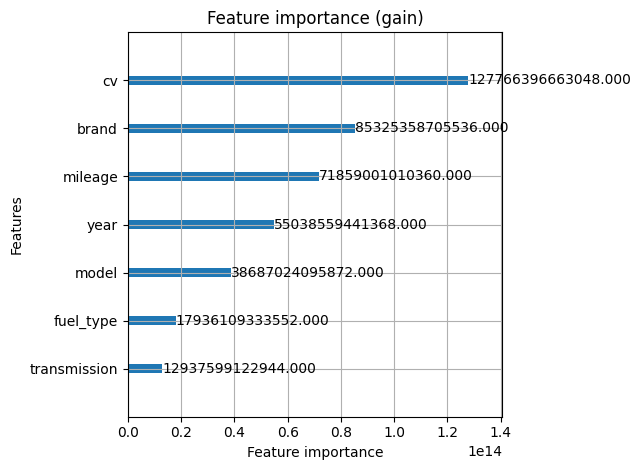

In [13]:
# Visualize feature importance

plt.figure(figsize=(8,6))
ax = lgb.plot_importance(bst, max_num_features=20, importance_type='gain')
plt.title('Feature importance (gain)')
plt.tight_layout()
plt.show()
